This version splits by baby instead of by record. but still overfitting and dominating jaundice.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">Proposed Method</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Loading Files</div>

In [11]:
# load the data frame
df = pd.read_csv('historical.csv')
fn_details = pd.read_csv('corrected_false_negatives.csv')

In [12]:
# get complete columns for false negative babies
fn_df = fn_details.merge(df, 
                         on=fn_details.columns.tolist(), 
                         how='left')

In [13]:
# ----------- STEP 1: Define Feature Types -----------
# Forward fill missing values
df['apgar_score'] = df['apgar_score'].ffill()

# Sepeparate features by data types
numerical_features = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
                     'birth_length_cm', 'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'oxygen_saturation', 'feeding_frequency_per_day','urine_output_count','stool_count',
                     'jaundice_level_mg_dl']

categorical_features = ['feeding_type', 'apgar_score']

binary_features = ['gender','immunizations_done', 'reflexes_normal']
for col in binary_features:
    df[col] = (
        df[col]
        .astype(str)
        .str.lower()
        .map({'yes': 1, 'male': 1, 'no': 0, 'female': 0})
        .fillna(0)
        .astype(int)  # ensure numeric dtype
    )
    
drop_col = ['baby_id', 'name', 'date']
target = df['risk_level']

In [16]:
# ----------- STEP 2: Define Features and Target -----------
unique_babies = df['baby_id'].unique()
train_babies, test_babies = train_test_split(unique_babies, test_size=0.2, random_state=42)

train_df = df[df['baby_id'].isin(train_babies)]
test_df = df[df['baby_id'].isin(test_babies)]

X_train = train_df.drop(columns=['risk_level'])
y_train = train_df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values

X_test = test_df.drop(columns=['risk_level'])
y_test = test_df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values

/tmp/ipykernel_67295/3645195685.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = train_df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values
/tmp/ipykernel_67295/3645195685.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test_df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values


In [17]:
# ----------- STEP 3: Preprocessing Pipeline -----------

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

# Fit preprocessor to get feature names
preprocessor.fit(X_train)
feature_names_out = preprocessor.get_feature_names_out()

numerical_count = len(numerical_features)
new_categorical_features = preprocessor.named_transformers_['cat']
categorical_count = len(new_categorical_features.get_feature_names_out())
binary_count = len(binary_features)

indices = list(range(numerical_count, numerical_count + categorical_count + binary_count))

# Parameter grids for hyperparameter tuning
params = {
    'Random Forest': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [5, 7, 9, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1]
    }
}

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(loss="log_loss", random_state=42)
}

In [18]:
results = []
trained_models = {}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    pipe = imb_pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTENC(categorical_features=indices,
                          random_state=42)),
        ("clf", model)
        
    ])

    rcv = RandomizedSearchCV(pipe, params[name], 
                             random_state=0, scoring='f1', cv=kfold)
    search = rcv.fit(X_train, y_train)
    
    best_params = search.best_params_
    best_model = search.best_estimator_
    print(best_params)
    trained_models[name] = best_model
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Train_Acc': accuracy_score(y_train, y_train_pred),
        'Test_Acc': accuracy_score(y_test, y_test_pred),
        'Train_F1': f1_score(y_train, y_train_pred),
        'Test_F1': f1_score(y_test, y_test_pred),
        'Train_Precision': precision_score(y_train, y_train_pred),
        'Test_Precision': precision_score(y_test, y_test_pred),
        'Train_Recall': recall_score(y_train, y_train_pred),
        'Test_Recall': recall_score(y_test, y_test_pred),
    })

# ----------- STEP 6: Show Results -----------

results_df = pd.DataFrame(results).sort_values(by='Test_F1', ascending=False).reset_index(drop=True)
print(results_df)


Training: Random Forest
{'smote__k_neighbors': 5, 'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}

Training: Gradient Boosting
{'smote__k_neighbors': 7, 'clf__n_estimators': 300, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}
               Model  Train_Acc  Test_Acc  Train_F1   Test_F1  \
0  Gradient Boosting   1.000000  0.997619  1.000000  0.991150   
1      Random Forest   0.999405  0.990476  0.997743  0.964286   

   Train_Precision  Test_Precision  Train_Recall  Test_Recall  
0              1.0        0.982456      1.000000     1.000000  
1              1.0        0.964286      0.995495     0.964286  


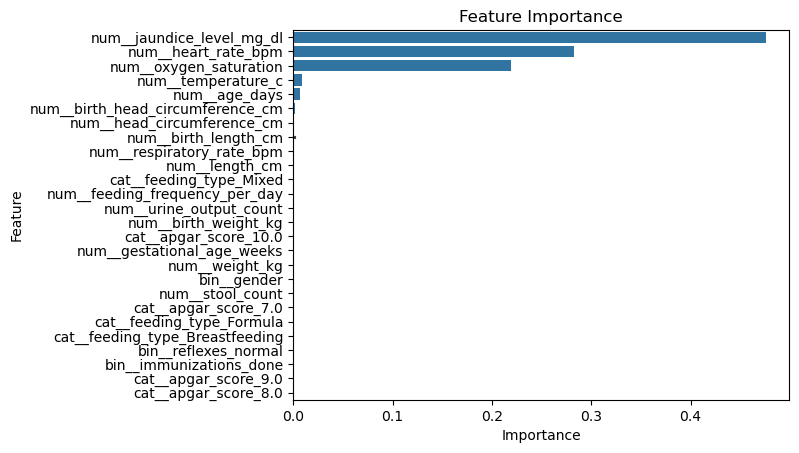

In [22]:
rf_model = GradientBoostingClassifier(random_state=42, 
                                      n_estimators=300, max_depth=5,
                                      learning_rate=0.1)

best_pipe = imb_pipeline([
        ("preprocessor", preprocessor),
        ("sample", SMOTENC(categorical_features=indices,
                           k_neighbors=7,
                          random_state=42)),
        ("clf", rf_model)
    ])

best_pipe.fit(X_train, y_train)

FEATURE_NAMES_NEW = preprocessor.get_feature_names_out()
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': FEATURE_NAMES_NEW,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [23]:
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       0.98      1.00      0.99        56

    accuracy                           1.00       420
   macro avg       0.99      1.00      0.99       420
weighted avg       1.00      1.00      1.00       420

     0   1
0  363   1
1    0  56
